<a href="https://colab.research.google.com/github/HoseinNekouei/Data_Augmentation_Gemini/blob/main/Gemini_Data_Augmentation_v_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Augmentaion via Gemini 1.0 pro


In [1]:
! pip install datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [15]:
import google.generativeai as genai
from google.colab import userdata

# Add Google API key in secret manager
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY_ATENA')

# Configure the genai library with the API key
genai.configure(api_key=GOOGLE_API_KEY)

In [16]:
def generate_text(prompt):
  """
  Generates text based on a given prompt using a specified generative model and configuration.

  This function initializes a generative model and a generation configuration, then uses the model
  to generate content based on the provided prompt. It includes safety settings to allow certain
  categories of potentially harmful content.

  Args:
      prompt (str): The text prompt to generate content from.


  Returns:
      str: The generated text response from the model.


  Note:
        generation_config (dict): Configuration settings for text generation, including candidate count,
                                maximum output tokens, top_k, and temperature. This parameter is not
                                used within the function as the configuration is initialized inside
                                the function.

  Example:
      prompt = "Once upon a time in a faraway land,"
      response = generate_text(None, prompt, None)
      print(response)  # Output the generated text
  """

  model= genai.GenerativeModel('gemini-1.0-pro')

  generation_config= genai.types.GenerationConfig(
      candidate_count=1,
      max_output_tokens=36,
      # stop_sequences=['\n'],
      top_k=1,
      temperature= 1.0
  )

  response = model.generate_content(
    prompt,
    safety_settings= {
        'HARM_CATEGORY_HARASSMENT': 'BLOCK_NONE',
        'HARM_CATEGORY_HATE_SPEECH': 'BLOCK_NONE',
        'HARM_CATEGORY_SEXUALLY_EXPLICIT': 'BLOCK_NONE',
        'HARM_CATEGORY_DANGEROUS_CONTENT': 'BLOCK_NONE'},
    generation_config= generation_config
  )

  return response


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
from datasets import load_dataset

def load_paraphrized_tweets(dataset_url):
    """
    Loads and processes a dataset of paraphrased tweets from a CSV file.

    This function loads the dataset from the provided URL, filters it to include
    only relevant columns ('text' and 'airline_sentiment'), and returns the processed dataset.

    Args:
        dataset_url (str): The URL or file path to the CSV file containing the dataset.

    Returns:
        DatasetDict: A dictionary-like object containing the loaded and processed dataset.

    Example:
        dataset_url = '/content/drive/MyDrive/dataset/US_airline/Parapherized_Tweets.csv'
        raw_data = load_paraphrized_tweets(dataset_url)
        print(raw_data['train'][:3])  # Print the first 3 records in the training set
    """

    # Load the CSV file in memory
    raw_data = load_dataset('csv', data_files=dataset_url, sep=',')

    # raw_data['train']= raw_data['train'].filter(lambda x: x['airline_sentiment_confidence']>= 0.9 )
    raw_data['train'] = raw_data['train'].filter(lambda x: len(x['text']) > 30)

    # Select only the 'text' and 'airline_sentiment' columns
    raw_data['train']= raw_data['train'].select_columns(['text', 'airline_sentiment'])

    return raw_data

In [19]:
def get_neutral_tweets(raw_data):
    """
    Filters and returns tweets with neutral sentiment from the given dataset.

    This function shuffles the dataset and then extracts tweets that have a neutral sentiment.

    Args:
        raw_data (DataFrame): The dataset containing tweets. It is expected to have a 'train'
                              column that includes a list of tweet dictionaries, and each
                              tweet dictionary should have an 'airline_sentiment' key.

    Returns:
        list: A list of dictionaries, each representing a tweet with a neutral sentiment.

    Example:
        raw_data = {
            'train': [
                {'airline_sentiment': 'neutral', 'text': 'Flight was okay.'},
                {'airline_sentiment': 'positive', 'text': 'Great service!'},
                {'airline_sentiment': 'neutral', 'text': 'No issues, decent experience.'},
            ]
        }

        neutral_tweets = get_neutral_tweets(raw_data)
        for tweet in neutral_tweets[:3]:
            print(tweet)
    """

    raw_data['train']= raw_data['train'].shuffle(812)

    neutral_tweets= [item for item in raw_data['train'] if item['airline_sentiment']=='neutral']

    return neutral_tweets

In [20]:
def get_positive_tweets(raw_data):
    """
    Filters and returns positive tweets from the given dataset.

    This function shuffles the dataset and then extracts tweets that have a positive sentiment.

    Args:
        raw_data (DataFrame): The dataset containing tweets. It is expected to have a 'train'
                              column that includes a list of tweet dictionaries, and each
                              tweet dictionary should have an 'airline_sentiment' key.

    Returns:
        list: A list of dictionaries, each representing a tweet with a positive sentiment.

    Example:
        raw_data = {
            'train': [
                {'airline_sentiment': 'positive', 'text': 'Great flight!'},
                {'airline_sentiment': 'negative', 'text': 'Terrible service.'},
                {'airline_sentiment': 'positive', 'text': 'Loved the experience!'},
            ]
        }

        positive_tweets = get_positive_tweets(raw_data)
        for tweet in positive_tweets[:3]:
            print(tweet)
    """

    raw_data['train']= raw_data['train'].shuffle(812)

    positive_tweets= [item for item in raw_data['train'] if item['airline_sentiment']=='positive']

    return positive_tweets


In [21]:
def get_negative_tweets(raw_data):
    """
    Filters and returns negative tweets from the given dataset.

    This function shuffles the dataset and then extracts tweets that have a negative sentiment.

    Args:
        raw_data (DataFrame): The dataset containing tweets. It is expected to have a 'train'
                              column that includes a list of tweet dictionaries, and each
                              tweet dictionary should have an 'airline_sentiment' key.

    Returns:
        list: A list of dictionaries, each representing a tweet with a negative sentiment.

    Example:
        raw_data = {
            'train': [
                {'airline_sentiment': 'positive', 'text': 'Great flight!'},
                {'airline_sentiment': 'negative', 'text': 'Terrible service.'},
                {'airline_sentiment': 'positive', 'text': 'Loved the experience!'},
            ]
        }

        negative_tweets = get_negative_tweets(raw_data)
        for tweet in negative_tweets[:3]:
            print(tweet)
    """

    raw_data['train']= raw_data['train'].shuffle(812)

    negative_tweets= [item for item in raw_data['train'] if item['airline_sentiment']=='negative']

    return negative_tweets


In [26]:
import time
from IPython.display import clear_output

def main(tweets, debug=False):
  '''
  Augment a dataset of neutral tweets by generating new text and saving it to a CSV file.

  This function generates new text based on a prompt, appends it to the existing dataset, and
  saves the updated dataset to a CSV file at regular intervals. It also introduces a delay
  between requests to avoid overloading the generation API.

  Parameters:
      tweets (list): List of neutral tweets to augment.
      debug (bool): Whether to run in debug mode (optional).

  Returns:
      None

  Notes:
      The function saves the updated dataset to a CSV file at regular intervals (every 10 iterations)
      and introduces a 5-second delay between requests to avoid overloading the generation API.
  '''

  # Iterate over the list of tweets, with index and tweet values
  for index, tweet in enumerate(tweets[:1014]):

    # Create a prompt string by concatenating a fixed prefix with the tweet's text
    prompt = "generate text that start by @[airline's name] like: " + tweet.get('text')

    # Extract the airline's sentiment from the tweet
    airline_sentiment= tweet.get('airline_sentiment')

    # Generate new text based on the prompt and configuration
    response = generate_text(prompt)

    # Create a dictionary to store the paraphrased text and its sentiment
    parapherize_text = {'text': response.text, 'airline_sentiment': airline_sentiment}

    # Add the paraphrased text and sentiment to the training dataset
    raw_data['train'] = raw_data['train'].add_item(parapherize_text)

    # Print a message indicating that the paraphrased text has been added to the dataset
    print(f'[Tweet {(index + 1)}]: {airline_sentiment}; added.')

    if debug:

      print(f'[prompt]: {prompt} ->  ({airline_sentiment})')

      # Print the paraphrased text, with the last generated text and its corresponding sentiment
      print(f"[parapherized_text]: {raw_data['train']['text'][-1]}-> ({raw_data['train']['airline_sentiment'][-1]})")

      print('------')


    # Check if the current iteration is a multiple of 10
    if (index + 1) % 10 == 0:

      # Save the updated dataset to a CSV file
      raw_data['train'].to_csv('/content/drive/MyDrive/dataset/US_airline/Parapherized_Tweets.csv')

      # Clear the output to display the updated message
      clear_output()

      print(f'Dataset was updated in index: {(index + 1)}')

    # Introduce a 5-second delay between requests to avoid overloading the generation API
    time.sleep(2)

In [23]:
import matplotlib.pyplot as plt
import pandas

def results(orginal_dataset_url):
  """
  Load and visualize the original and augmented datasets.

  This function loads the original dataset from a CSV file, filters it to only include
  tweets with a sentiment confidence of at least 0.9, and then visualizes the
  original and augmented datasets using bar charts.

  Returns:
      None
  """

  original_dataset = load_dataset('csv', data_files= orginal_dataset_url)
  original_dataset['train']= original_dataset['train'].filter(lambda x: x['airline_sentiment_confidence']>= 0.9 )


  # train_labels = dataset.set_format('pandas')
  df_original_dataset= original_dataset['train'].to_pandas()

  df_augmented_dataset= raw_data['train'].to_pandas()

  print(f'df_original_dataset: {len(df_original_dataset)}')

  print(f'df_augmented_dataset: {len(df_augmented_dataset)}')

  df_original = df_original_dataset['airline_sentiment'].value_counts()

  df_augmented = df_augmented_dataset['airline_sentiment'].value_counts()

  print('')
  print(df_original)
  print(df_augmented)

  # Plot the bar chart for train and test label distributions
  plt.figure(figsize=(10, 4))

  plt.subplot(1,2,1)
  plt.bar(df_original.index, df_original.values, color= 'green')
  plt.title('Original dataset')

  plt.subplot(1, 2, 2)
  plt.bar(df_augmented.index, df_augmented.values, color='blue')
  plt.title('Augmented dataset')

  plt.tight_layout()
  plt.show()

Dataset was updated in index: 1010
[Tweet 1011]: negative; added.
[Tweet 1012]: negative; added.
[Tweet 1013]: negative; added.
[Tweet 1014]: negative; added.
df_original_dataset: 10458
df_augmented_dataset: 25104

airline_sentiment
negative    7391
neutral     1550
positive    1517
Name: count, dtype: int64
airline_sentiment
neutral     8386
positive    8380
negative    8338
Name: count, dtype: int64


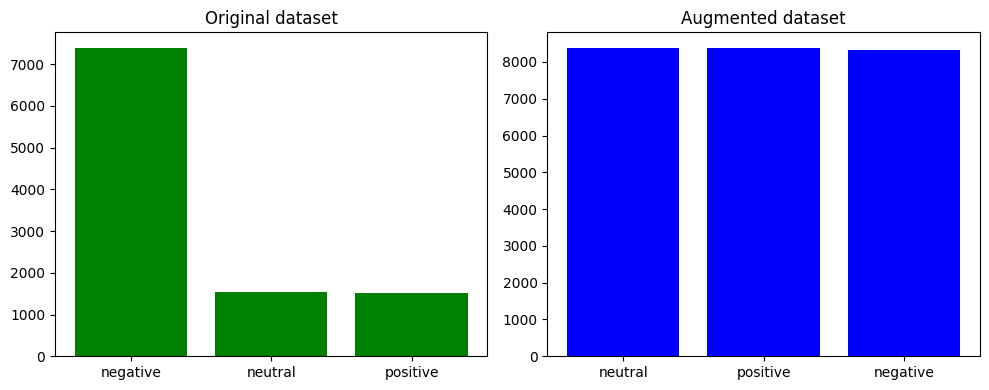

In [27]:
"""
This script processes a dataset of tweets about US airlines. It loads the dataset,
filters tweets based on sentiment, and performs further analysis on the positive tweets.

Usage:
    Run the script directly to execute the main processing and analysis pipeline.

Variables:
    raw_dataset_url (str): The file path to the paraphrased tweets dataset.
    raw_data (DataFrame): The loaded dataset containing paraphrased tweets.
    neutral_tweets (DataFrame): The subset of tweets with a neutral sentiment.
    positive_tweets (DataFrame): The subset of tweets with a positive sentiment.
    original_dataset_url (str): The file path to the original tweets dataset.

Functions:
    load_paraphrized_tweets(url): Loads the dataset from the given URL and returns it as a DataFrame.
    get_neutral_tweets(data): Filters and returns the neutral tweets from the dataset.
    get_positive_tweets(data): Filters and returns the positive tweets from the dataset.
    results(url): Performs some analysis or processing on the dataset at the given URL.
    main(tweets): The main function that processes the positive tweets.

Exceptions:
    If an error occurs in the main function, it is caught and printed to the console.

Example:
    To run the script, simply execute it in a Python environment:

    $ python script_name.py

Note:
    Make sure that the dataset files are available at the specified paths before running the script.
"""

if __name__ == '__main__':

  raw_dataset_url= '/content/drive/MyDrive/dataset/US_airline/Parapherized_Tweets.csv'

  orginal_dataset_url='/content/drive/MyDrive/dataset/US_airline/Tweets.csv'

  raw_data = load_paraphrized_tweets(raw_dataset_url)

  neutral_tweets= get_neutral_tweets(raw_data)

  positive_tweets = get_positive_tweets(raw_data)

  negative_tweets = get_negative_tweets(raw_data)

  # Run the main function with the positive/neutral tweets
  try:
    main(tweets= negative_tweets)

  except Exception as e:
    print(e)

  results(orginal_dataset_url)


In [25]:
# 1014 negative
# 1565 positive
